In [1]:
import tensorflow as tf
import os 

In [2]:
gpus = tf.config.experimental.list_physical_devices('CPU')


In [3]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
#avoid oom errors by setting gpu memory consupmtion growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Remove dodgy images

In [5]:
import cv2
import imghdr 

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\overexposure\1216x819x2.jpg
Image not in ext list data\overexposure\192px.svg
Image not in ext list data\overexposure\72007010-overexposed-portrait-of-beautiful-young-blonde-woman-with-green.jpg
Image not in ext list data\overexposure\Banner_how-to_fix_Overexposed_images-_in-photoshop.webp
Image not in ext list data\overexposure\cheerful-woman-spending-happy-time-260nw-613509782.jpg
Image not in ext list data\overexposure\Copy-of-Copy-of-Untitled.jpg
Image not in ext list data\overexposure\cover-how-to-fix-overexposed-photos.webp
Image not in ext list data\overexposure\fix-exposure-before-after.webp
Image not in ext list data\overexposure\fixing-overexposure-in-lightroom.jpg
Image not in ext list data\overexposure\image-04.gif
Image not in ext list data\overexposure\juist_belicht.jpg
Image not in ext list data\overexposure\mvd_sunset2_350.jpg
Image not in ext list data\overexposure\Original-Photo-1440x960.jpg
Image not in ext list data\overexposure\rice-field

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 582 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [82]:
batch = data_iterator.next()

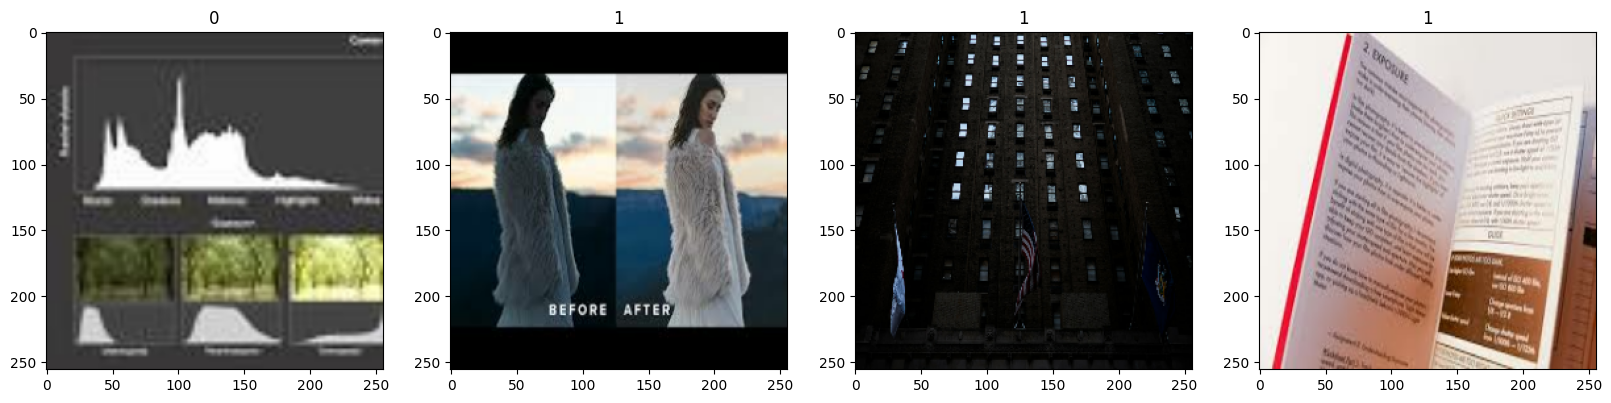

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [86]:
data = data.map(lambda x,y: (x/255, y))

In [87]:
data.as_numpy_iterator().next()

(array([[[[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          ...,
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.00392157]],
 
         ...,
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train_size

13

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
13/13 [==============================] - 5s 312ms/step - loss: 0.6928 - accuracy: 0.6418 - val_loss: 0.5259 - val_accuracy: 0.7812
Epoch 2/20
13/13 [==============================] - 4s 301ms/step - loss: 0.5364 - accuracy: 0.7284 - val_loss: 0.5197 - val_accuracy: 0.7292
Epoch 3/20
13/13 [==============================] - 4s 299ms/step - loss: 0.4935 - accuracy: 0.7620 - val_loss: 0.4459 - val_accuracy: 0.7708
Epoch 4/20
13/13 [==============================] - 4s 303ms/step - loss: 0.4655 - accuracy: 0.7837 - val_loss: 0.4160 - val_accuracy: 0.8021
Epoch 5/20
13/13 [==============================] - 4s 303ms/step - loss: 0.4362 - accuracy: 0.8149 - val_loss: 0.5335 - val_accuracy: 0.7188
Epoch 6/20
13/13 [==============================] - 4s 303ms/step - loss: 0.3843 - accuracy: 0.8245 - val_loss: 0.3430 - val_accuracy: 0.8542
Epoch 7/20
13/13 [==============================] - 4s 306ms/step - loss: 0.3396 - accuracy: 0.8750 - val_loss: 0.3613 - val_accuracy: 0.8438
Epoch 

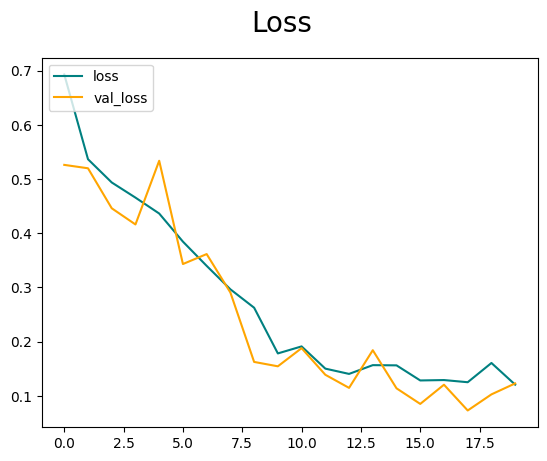

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

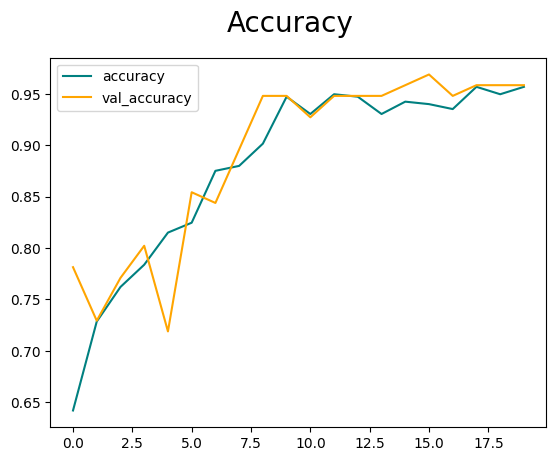

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 206ms/step


In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.8636364, shape=(), dtype=float32) tf.Tensor(0.90625, shape=(), dtype=float32)


In [33]:
import cv2

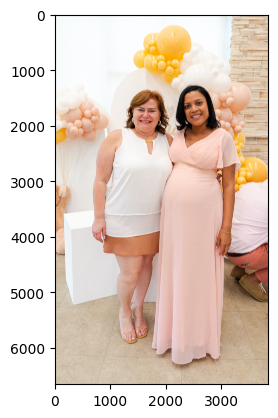

In [70]:
img = cv2.imread('DSC04854.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

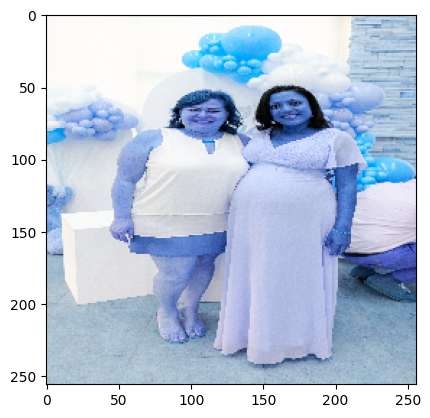

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [75]:
resize.shape

TensorShape([256, 256, 3])

In [73]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [74]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [76]:
yhat

array([[0.725092]], dtype=float32)

In [85]:
if yhat > 0.5: 
    print(f'Photo is underexposed')
else:
    print(f'Photo is overexposed')

Photo is underexposed
